In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Load Raw Data
# ==============================
file_path = r"C:\upgradMentornship\JUPYTER\Trafficproject.csv"


In [3]:
# Some CSVs contain special characters, so we use latin1 encoding
df = pd.read_csv(file_path, encoding='latin1')

In [4]:
# Convert Time_stamp column to proper datetime
df['Time_stamp'] = pd.to_datetime(df['Time_stamp'], format="%d-%m-%Y %H:%M", errors='coerce')


print("✅ Raw Data Loaded")
print(df.head())
print(df.info())

✅ Raw Data Loaded
           Time_stamp  Junction_id  Traffic_volume     Recod_Id  \
0 2015-11-01 00:00:00            1              16  20151101001   
1 2015-11-01 01:00:00            1              15  20151101011   
2 2015-11-01 02:00:00            1              13  20151101021   
3 2015-11-01 03:00:00            1              34  20151101031   
4 2015-11-01 04:00:00            1              16  20151101041   

   Temperature_c  Has_Rain  Is_Event  Is_Weekend  
0             27         0         0           1  
1             29         0         0           0  
2             25         0         1           1  
3             24         0         0           0  
4             28         0         1           1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Time_stamp      48120 non-null  datetime64[ns]
 1   Junc

In [8]:
# Handle missing values (forward fill for time series)
df = df.ffill()


# Remove duplicates
df = df.drop_duplicates()


# Make sure Time_stamp is the index (if not already set)
if 'Time_stamp' in df.columns:
    df = df.set_index('Time_stamp')

In [9]:
# Aggregate Hourly Data
# ==============================
df_hourly = df.groupby('Junction_id').resample('H').agg({
'Traffic_volume': 'sum',
'Temperature_c': 'mean',
'Has_Rain': 'mean',
'Is_Event': 'max',
'Is_Weekend': 'max'
}).reset_index()


print("✅ Aggregated Data")
print(df_hourly.head())

C:\Users\ashwithakasarla\AppData\Local\Temp\ipykernel_33152\4235260899.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.groupby('Junction_id').resample('H').agg({


✅ Aggregated Data
   Junction_id          Time_stamp  Traffic_volume  Temperature_c  Has_Rain  \
0            1 2015-11-01 00:00:00              16           27.0       0.0   
1            1 2015-11-01 01:00:00              15           29.0       0.0   
2            1 2015-11-01 02:00:00              13           25.0       0.0   
3            1 2015-11-01 03:00:00              34           24.0       0.0   
4            1 2015-11-01 04:00:00              16           28.0       0.0   

   Is_Event  Is_Weekend  
0         0           1  
1         0           0  
2         1           1  
3         0           0  
4         1           1  


In [10]:
# Step 5: Preprocessing (Normalization)
# ==============================
scaler = StandardScaler()
df_hourly[['Traffic_volume','Temperature_c','Has_Rain']] = scaler.fit_transform(
df_hourly[['Traffic_volume','Temperature_c','Has_Rain']]
)


print("✅ Normalized Data")
print(df_hourly.head())

✅ Normalized Data
   Junction_id          Time_stamp  Traffic_volume  Temperature_c  Has_Rain  \
0            1 2015-11-01 00:00:00       -0.327373      -0.294412       0.0   
1            1 2015-11-01 01:00:00       -0.375567       0.876520       0.0   
2            1 2015-11-01 02:00:00       -0.471954      -1.465343       0.0   
3            1 2015-11-01 03:00:00        0.540112      -2.050809       0.0   
4            1 2015-11-01 04:00:00       -0.327373       0.291054       0.0   

   Is_Event  Is_Weekend  
0         0           1  
1         0           0  
2         1           1  
3         0           0  
4         1           1  


In [12]:
# Step 6: Feature Engineering
# ==============================
# Time-based features
df_hourly['Hour'] = df_hourly['Time_stamp'].dt.hour
df_hourly['DayOfWeek'] = df_hourly['Time_stamp'].dt.dayofweek
df_hourly['Month'] = df_hourly['Time_stamp'].dt.month


# Lag features (previous 1, 3, 6 hours traffic volume)
for lag in [1, 3, 6]:
    df_hourly[f'Lag_{lag}h'] = df_hourly.groupby('Junction_id')['Traffic_volume'].shift(lag)


# Drop NaN rows caused by lagging
df_hourly = df_hourly.dropna()


print("✅ Feature Engineering Done")
print(df_hourly.head())

✅ Feature Engineering Done
    Junction_id          Time_stamp  Traffic_volume  Temperature_c  Has_Rain  \
6             1 2015-11-01 06:00:00       -0.712922       2.632917       0.0   
7             1 2015-11-01 07:00:00        0.443725       0.876520       0.0   
8             1 2015-11-01 08:00:00       -0.616534       2.047451       0.0   
9             1 2015-11-01 09:00:00       -0.327373      -3.221741       0.0   
10            1 2015-11-01 10:00:00       -0.471954      -0.294412       0.0   

    Is_Event  Is_Weekend  Hour  DayOfWeek  Month    Lag_1h    Lag_3h    Lag_6h  
6          0           0     6          6     11 -0.327373  0.540112 -0.327373  
7          0           1     7          6     11 -0.712922 -0.327373 -0.375567  
8          1           0     8          6     11  0.443725 -0.327373 -0.471954  
9          1           1     9          6     11 -0.616534 -0.712922  0.540112  
10         0           1    10          6     11 -0.327373  0.443725 -0.327373  


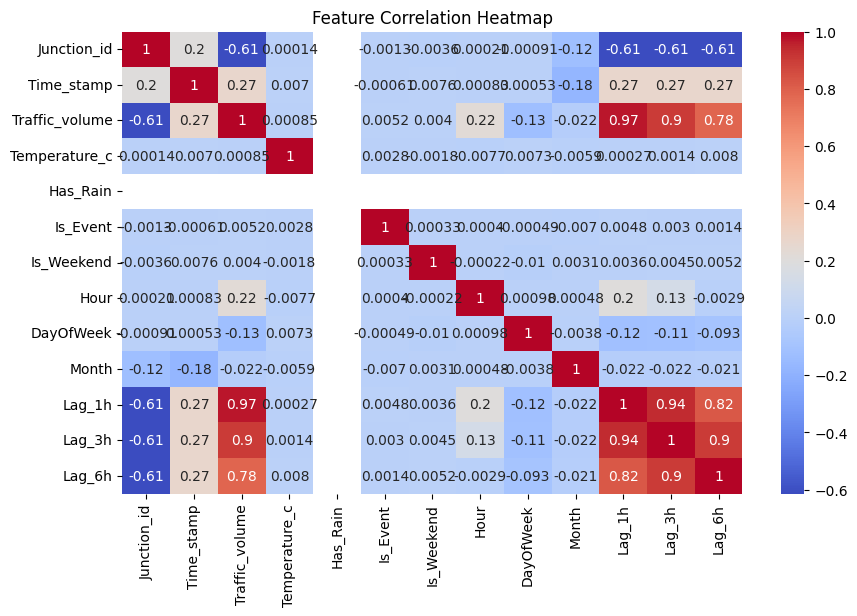

✅ Feature Importance
          Feature  Importance
8          Lag_1h    0.944187
5            Hour    0.019513
9          Lag_3h    0.009793
10         Lag_6h    0.008157
7           Month    0.005310
6       DayOfWeek    0.004500
1   Temperature_c    0.003378
0     Junction_id    0.002889
4      Is_Weekend    0.001175
3        Is_Event    0.001098
2        Has_Rain    0.000000


In [13]:
# Step 7: Feature Selection
# ==============================
plt.figure(figsize=(10,6))
sns.heatmap(df_hourly.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


# Feature importance with Random Forest
X = df_hourly.drop(['Traffic_volume','Time_stamp'], axis=1)
y = df_hourly['Traffic_volume']


rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)


feature_importance = pd.DataFrame({
'Feature': X.columns,
'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)


print("✅ Feature Importance")
print(feature_importance)

In [14]:
# Step 8: Save Processed Data
# ==============================
output_path = r"C:\upgradMentornship\JUPYTER\Trafficproject_processed.csv"
df_hourly.to_csv(output_path, index=False)


print(f"✅ Processed dataset saved at: {output_path}")

✅ Processed dataset saved at: C:\upgradMentornship\JUPYTER\Trafficproject_processed.csv
